# HOMEWORK 13

In this homework you are going to build your first classifier for the CIFAR-10 dataset. This dataset contains 10 different classes and you can learn more about it [here](https://www.cs.toronto.edu/~kriz/cifar.html). This homework consists of the following tasks:
* Dataset inspection
* Building the network
* Training
* Evaluation

At the end, as usual, there will be a couple of questions for you to answer :-)

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input, MaxPooling2D
from tensorflow.keras import Model
from time import time

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

# Set the seeds for reproducibility
from numpy.random import seed
from tensorflow.random import set_seed
seed_value = 1234578790
seed(seed_value)
set_seed(seed_value)

2024-07-23 03:22:32.908189: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Step 0: Dataset Inspection

Load the dataset and make a quick inspection.

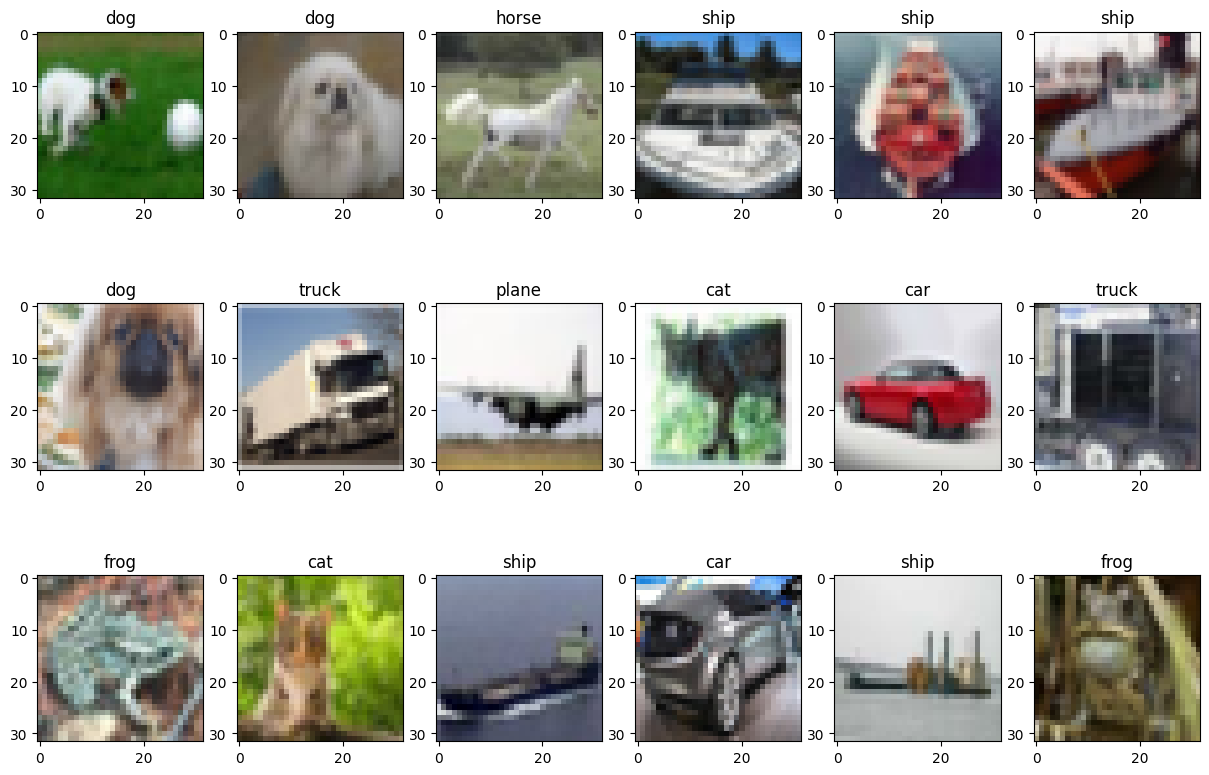

In [2]:
# Load the dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
# Mapping from class ID to class name
classes = {0:'plane', 1:'car', 2:'bird', 3:'cat', 4:'deer',
           5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}

# Dataset params
num_classes = len(classes)
size = x_train.shape[1]

# Visualize random samples (as a plot with 3x6 samples)
for ii in range(18):    
    plt.subplot(3,6,ii+1)
    # Pick a random sample
    idx = np.random.randint(0, x_train.shape[0])
    # Show the image and the label
    plt.imshow(x_train[idx, ...])
    plt.title(classes[int(y_train[idx])])

Compute the class histogram (you can visualize it if you want). Is the dataset balanced?

Hint: You might find [Counter](https://docs.python.org/3/library/collections.html#collections.Counter) tool useful. In any case, it's up to you how you compute the histogram.

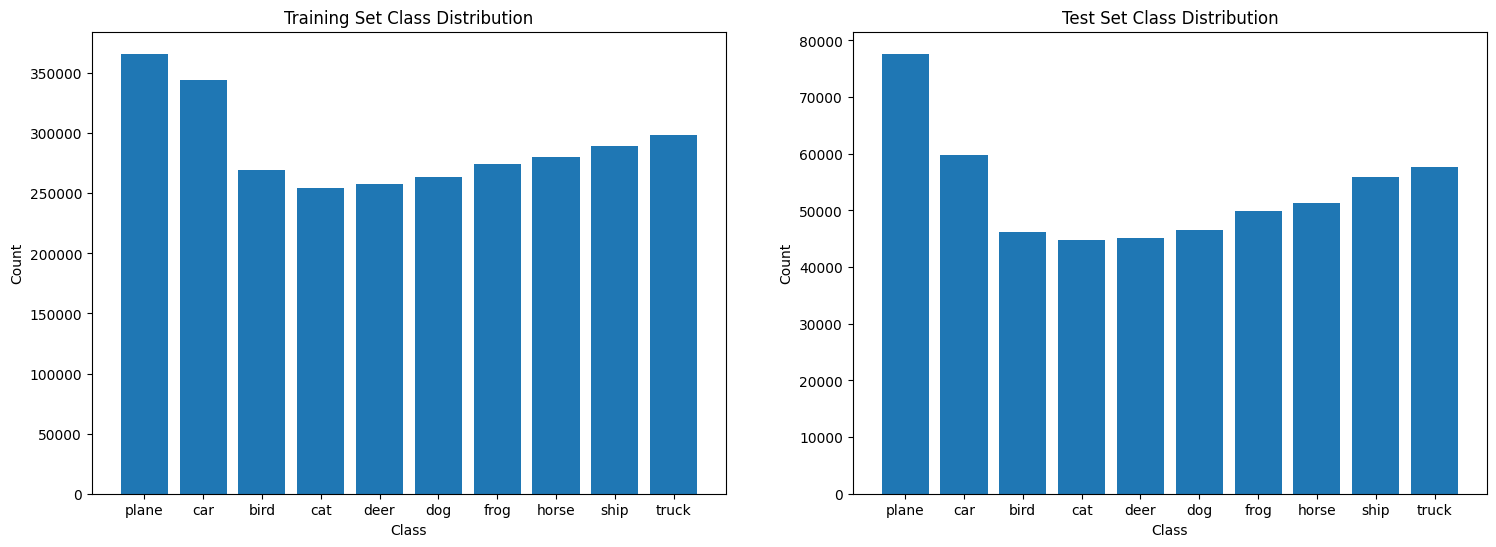

In [3]:
# Compute the class histogram
from collections import Counter

train_histogram = Counter(x_train.flatten())
test_histogram = Counter(x_test.flatten())

# Convert histograms to lists for plotting
train_counts = [train_histogram[i] for i in range(num_classes)]
test_counts = [test_histogram[i] for i in range(num_classes)]

# Plot the histograms
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

ax[0].bar(classes.values(), train_counts)
ax[0].set_title('Training Set Class Distribution')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Count')

ax[1].bar(classes.values(), test_counts)
ax[1].set_title('Test Set Class Distribution')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Count')

plt.show()

### Step 1: Data Preparation

In this step, you'll need to prepare the data for training, i.e., you will have to normalize it and encode the labels as one-hot vectors.

In [4]:
# Normalization
x_train = x_train / 255
x_test = x_test / 255

# One-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

print('Train set:   ', len(y_train), 'samples')
print('Test set:    ', len(y_test), 'samples')
print('Sample dims: ', x_train.shape)

Train set:    50000 samples
Test set:     10000 samples
Sample dims:  (50000, 32, 32, 3)


### Step 2: Building the Classifier

Build the CNN for CIFAR10 classification. For starters, you can use the same network we used in the lesson for the MNIST problem.

In [5]:
inputs = Input(shape=(size, size, 3))

net = Conv2D(16, kernel_size=(3, 3), activation="relu")(inputs)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Conv2D(32, kernel_size=(3, 3), activation="relu")(net)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Flatten()(net)
outputs = Dense(num_classes, activation="softmax")(net)

model = Model(inputs, outputs)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        11,530 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,618 (64.91 KB)

 Trainable params: 16,618 (64.91 KB)

 Non-trainable params: 0 (0.00 B)

### Step 3: Training

Compile the model and train it.

In [6]:
epochs = 25
batch_size = 128

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

start = time()
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)
print('Elapsed time', time() - start)

Epoch 1/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.3035 - loss: 1.9218 - val_accuracy: 0.4450 - val_loss: 1.5843
Epoch 2/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.4872 - loss: 1.4478 - val_accuracy: 0.5026 - val_loss: 1.4149
Epoch 3/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.5319 - loss: 1.3385 - val_accuracy: 0.5440 - val_loss: 1.2979
Epoch 4/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.5574 - loss: 1.2677 - val_accuracy: 0.5668 - val_loss: 1.2345
Epoch 5/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.5783 - loss: 1.2118 - val_accuracy: 0.5870 - val_loss: 1.1903
Epoch 6/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.5948 - loss: 1.1658 - val_accuracy: 0.6004 - val_loss: 1.1601
Epoch 7/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.6107 - loss: 1.1263 - val_accuracy: 0.6098 - val_loss: 1.1292
Epoch 8/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.6251 - loss: 1.0928 - val_ac

Train Acc      0.708311140537262
Validation Acc 0.6808000206947327


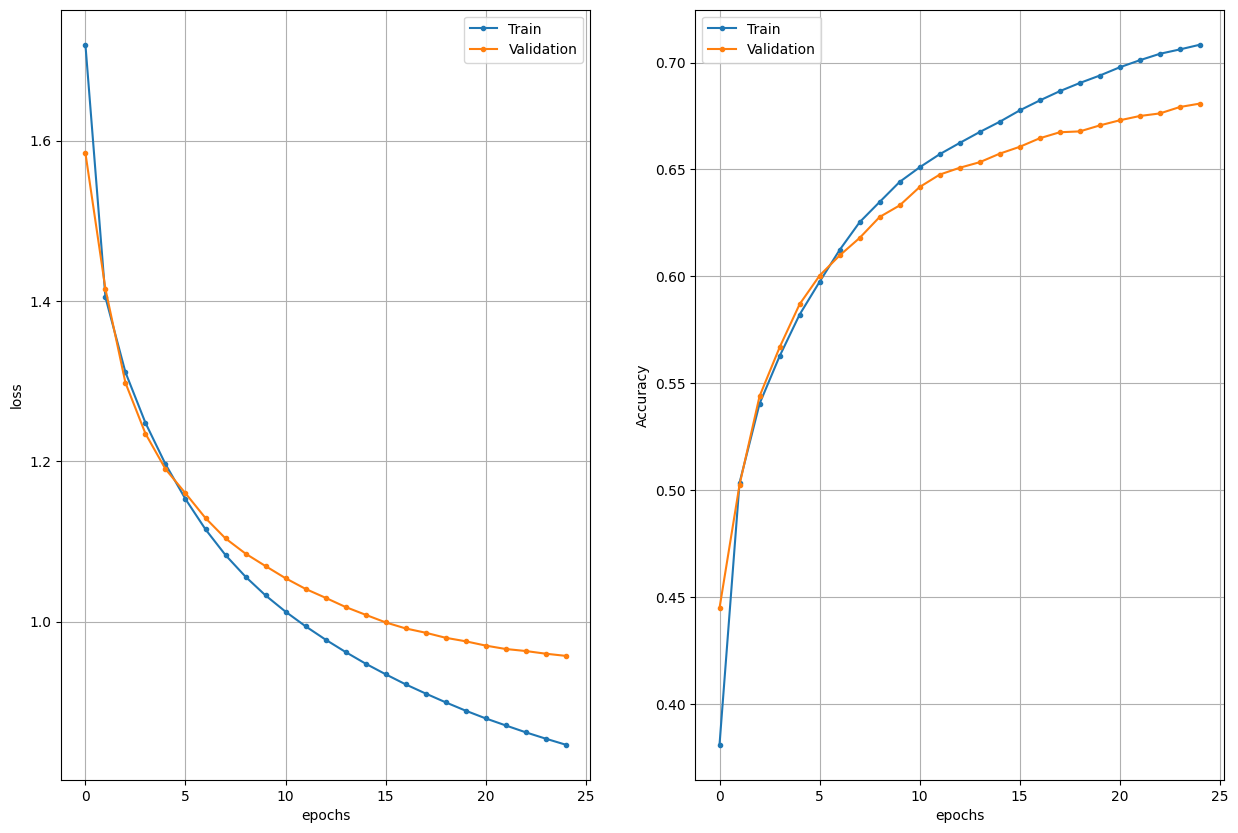

In [7]:
# Show training history (this cell is complete, nothing to implement here :-) )
h = history.history
epochs = range(len(h['loss']))

plt.subplot(121), plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
plt.legend(['Train', 'Validation'])
plt.subplot(122), plt.plot(epochs, h['accuracy'], '.-',
                           epochs, h['val_accuracy'], '.-')
plt.grid(True), plt.xlabel('epochs'), plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

print('Train Acc     ', h['accuracy'][-1])
print('Validation Acc', h['val_accuracy'][-1])    

### Step 4: Evaluation

In this step, you have to calculate the accuracies and visualize some random samples. For the evaluation, you are going to use the test split from the dataset.

In [8]:
# Compute the labels and the predictions as sparse values
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(model.predict(x_test), axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step


In [9]:
# Compute and print the accuracy for each class

for class_id, class_name in classes.items():
    class_indices = np.where(y_true == class_id)[0]
    class_accuracy = np.mean(y_true[class_indices] == y_pred[class_indices])
    print(f'{class_name}: {class_accuracy:.4f}')

plane: 0.7300
car: 0.7270
bird: 0.4660
cat: 0.4130
deer: 0.7340
dog: 0.5480
frog: 0.8160
horse: 0.7140
ship: 0.7050
truck: 0.7520


In [10]:
# Print the overall stats
ev = model.evaluate(x_test, y_test)
print('Test loss  ', ev[0])
print('Test metric', ev[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.6646 - loss: 0.9767
Test loss   0.9919909238815308
Test metric 0.6604999899864197


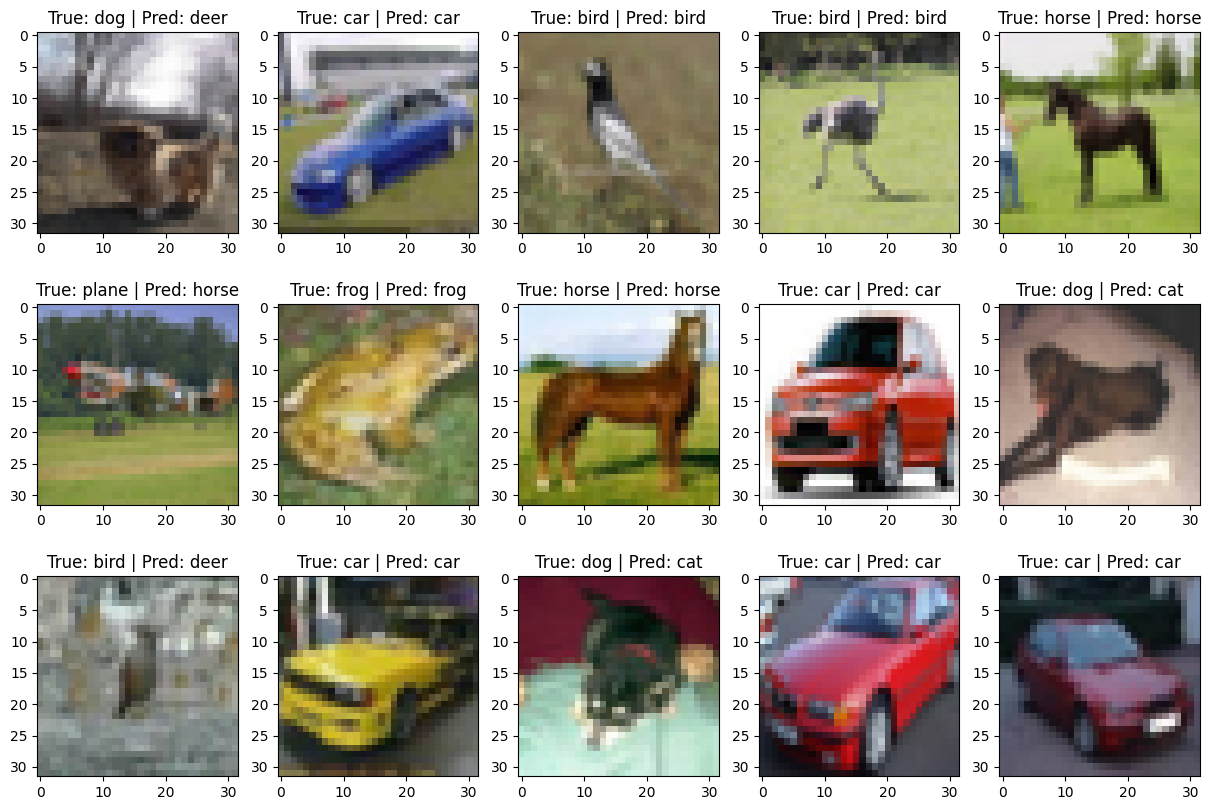

In [11]:
# Show random samples
for ii in range(15):
    # Pick a random sample
    idx = np.random.randint(0, x_test.shape[0])
    # Show the results
    plt.subplot(3,5,ii+1), plt.imshow(x_test[idx, ...])
    plt.title('True: ' + str(classes[y_true[idx]]) + ' | Pred: ' + str(classes[y_pred[idx]]))

### Questions
* What is the overall accuracy of the classifier?
* What modifications would you do in order to improve the classification accuracy?
* Make **one** modification (that you think can help) and train the classifier again. Does the accuracy improve?

Overall accuracy is near 0.6605. We can add more loops(epochs) but I think we will get not more than 0.75. So, I will try more layers + batch normalization. This will take much more time but accuracy must be much better

In [13]:
from tensorflow.keras.layers import BatchNormalization, Dropout

inputs = Input(shape=(size, size, 3))

net = Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same')(inputs)
net = BatchNormalization()(net)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Conv2D(64, kernel_size=(3, 3), activation="relu", padding='same')(net)
net = BatchNormalization()(net)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Conv2D(128, kernel_size=(3, 3), activation="relu", padding='same')(net)
net = BatchNormalization()(net)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Flatten()(net)
net = Dense(256, activation="relu")(net)
net = Dropout(0.5)(net)
outputs = Dense(num_classes, activation="softmax")(net)

model = Model(inputs, outputs)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 621,258 (2.37 MB)

 Trainable params: 620,810 (2.37 MB)

 Non-trainable params: 448 (1.75 KB)

In [14]:
epochs = 25
batch_size = 128

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

start = time()
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)
print('Elapsed time', time() - start)

Epoch 1/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 64s 176ms/step - accuracy: 0.3533 - loss: 1.9646 - val_accuracy: 0.3452 - val_loss: 1.9885
Epoch 2/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 61s 174ms/step - accuracy: 0.5347 - loss: 1.3023 - val_accuracy: 0.6224 - val_loss: 1.0800
Epoch 3/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 59s 167ms/step - accuracy: 0.6223 - loss: 1.0738 - val_accuracy: 0.6702 - val_loss: 0.9361
Epoch 4/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 59s 167ms/step - accuracy: 0.6694 - loss: 0.9364 - val_accuracy: 0.7134 - val_loss: 0.8084
Epoch 5/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 59s 167ms/step - accuracy: 0.7086 - loss: 0.8266 - val_accuracy: 0.7276 - val_loss: 0.7941
Epoch 6/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 57s 163ms/step - accuracy: 0.7407 - loss: 0.7358 - val_accuracy: 0.7198 - val_loss: 0.8370
Epoch 7/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 59s 166ms/step - accuracy: 0.7681 - loss: 0.6600 - val_accuracy: 0.6428 - val_loss: 1.1509
Epoch 8/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 59s 169ms/step - accuracy: 0.7925 - loss: 0

Train Acc      0.93913334608078
Validation Acc 0.7092000246047974


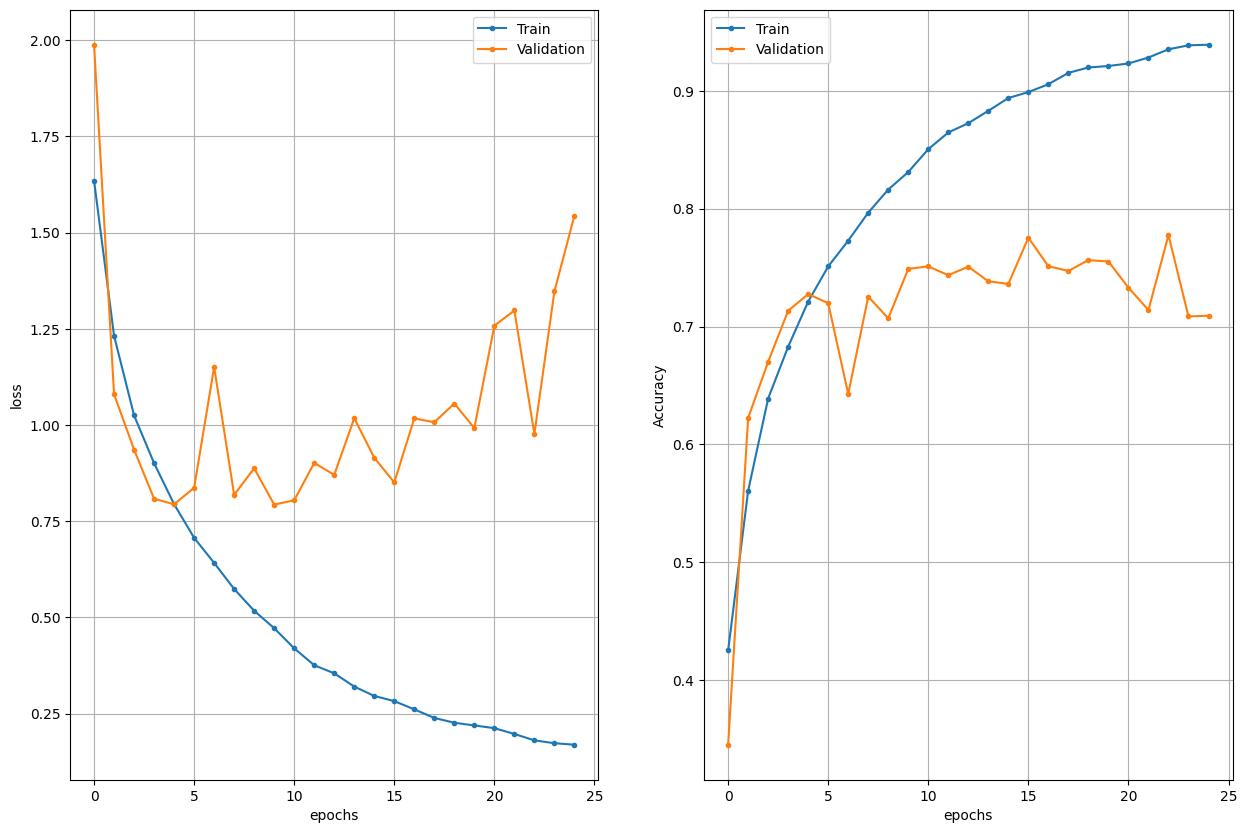

In [18]:
# Show training history (this cell is complete, nothing to implement here :-) )
h = history.history
epochs = range(len(h['loss']))

plt.subplot(121), plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
plt.legend(['Train', 'Validation'])
plt.subplot(122), plt.plot(epochs, h['accuracy'], '.-',
                           epochs, h['val_accuracy'], '.-')
plt.grid(True), plt.xlabel('epochs'), plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

print('Train Acc     ', h['accuracy'][-1])
print('Validation Acc', h['val_accuracy'][-1])    

In [17]:
# Compute the labels and the predictions as sparse values
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(model.predict(x_test), axis=1)

for class_id, class_name in classes.items():
    class_indices = np.where(y_true == class_id)[0]
    class_accuracy = np.mean(y_true[class_indices] == y_pred[class_indices])
    print(f'{class_name}: {class_accuracy:.4f}')

# Print the overall stats
ev = model.evaluate(x_test, y_test)
print('Test loss  ', ev[0])
print('Test metric', ev[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step
plane: 0.8420
car: 0.9040
bird: 0.7760
cat: 0.4370
deer: 0.4480
dog: 0.3680
frog: 0.8160
horse: 0.7310
ship: 0.8640
truck: 0.7870
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.6906 - loss: 1.6406
Test loss   1.6003202199935913
Test metric 0.6973000168800354


I think here we have overfitting. Maybe instead of more layers, we can add more epochs 

In [19]:
inputs = Input(shape=(size, size, 3))

net = Conv2D(16, kernel_size=(3, 3), activation="relu")(inputs)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Conv2D(32, kernel_size=(3, 3), activation="relu")(net)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Flatten()(net)
outputs = Dense(num_classes, activation="softmax")(net)

model = Model(inputs, outputs)
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 30, 30, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 15, 15, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 13, 13, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │        11,530 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,618 (64.91 KB)

 Trainable params: 16,618 (64.91 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
epochs = 50
batch_size = 128

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

start = time()
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)
print('Elapsed time', time() - start)

Epoch 1/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.2863 - loss: 1.9607 - val_accuracy: 0.4244 - val_loss: 1.6441
Epoch 2/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.4641 - loss: 1.5133 - val_accuracy: 0.4730 - val_loss: 1.5107
Epoch 3/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.5121 - loss: 1.3882 - val_accuracy: 0.5058 - val_loss: 1.4082
Epoch 4/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.5436 - loss: 1.3112 - val_accuracy: 0.5412 - val_loss: 1.3151
Epoch 5/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.5653 - loss: 1.2495 - val_accuracy: 0.5678 - val_loss: 1.2442
Epoch 6/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.5824 - loss: 1.2006 - val_accuracy: 0.5820 - val_loss: 1.2004
Epoch 7/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.5975 - loss: 1.1607 - val_accuracy: 0.5948 - val_loss: 1.1670
Epoch 8/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.6106 - loss: 1.1256 - 

Train Acc      0.7305777668952942
Validation Acc 0.6729999780654907


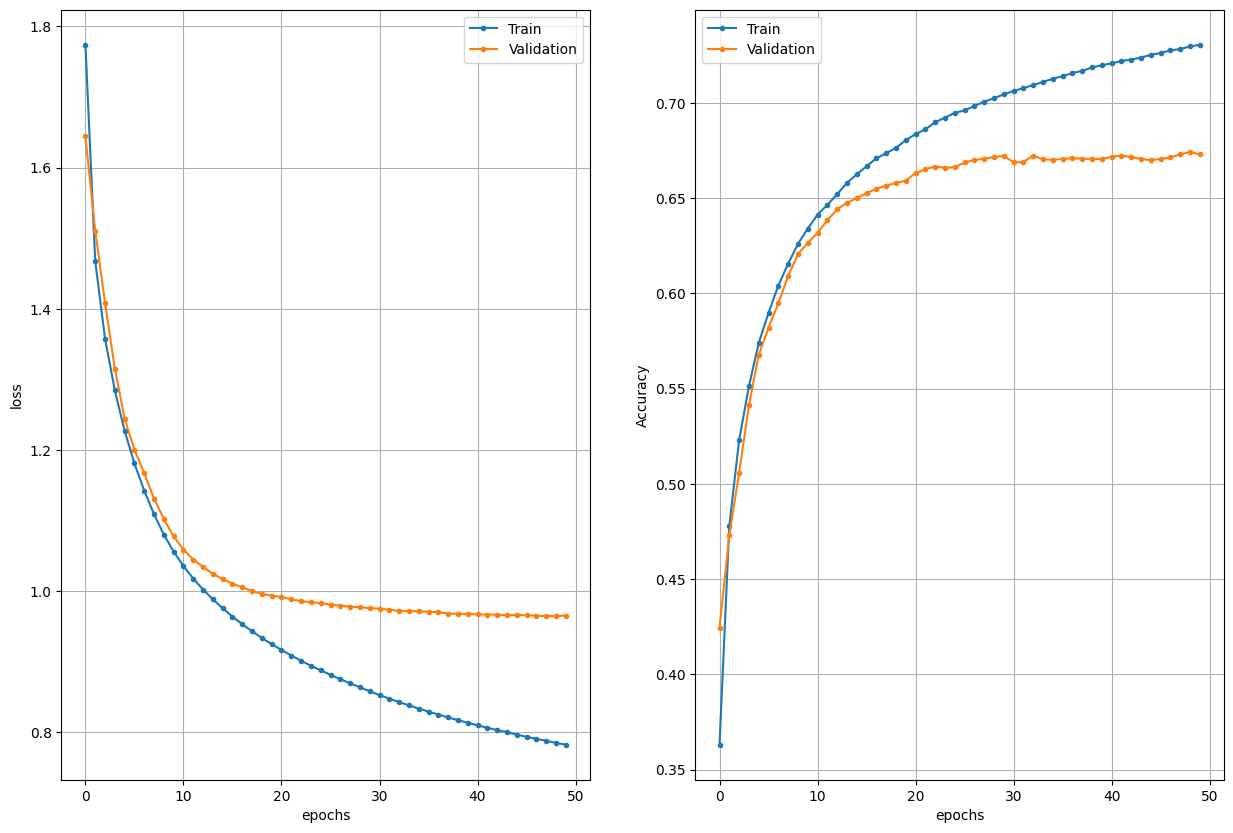

In [22]:
# Show training history (this cell is complete, nothing to implement here :-) )
h = history.history
epochs = range(len(h['loss']))

plt.subplot(121), plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
plt.legend(['Train', 'Validation'])
plt.subplot(122), plt.plot(epochs, h['accuracy'], '.-',
                           epochs, h['val_accuracy'], '.-')
plt.grid(True), plt.xlabel('epochs'), plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

print('Train Acc     ', h['accuracy'][-1])
print('Validation Acc', h['val_accuracy'][-1]) 

In [21]:
# Print the overall stats
ev = model.evaluate(x_test, y_test)
print('Test loss  ', ev[0])
print('Test metric', ev[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.6635 - loss: 0.9928
Test loss   0.997184157371521
Test metric 0.6646000146865845


Not too much difference from first model. Maybe we can experiment with other parameters